# Batched Obstacles

This notebook shows how to run fluid simulations with different obstacles in parallel.
Here, we use a rectangular obstacle located at three different positions.

In [1]:
from phi.flow import *

In [10]:
OBSTACLE_X = tensor([15, 30, 50], batch('obstacle_pos'))
OBSTACLE = Box(x=(OBSTACLE_X - 15, OBSTACLE_X + 15), y=(50, 70))

<Figure size 864x360 with 3 Axes>

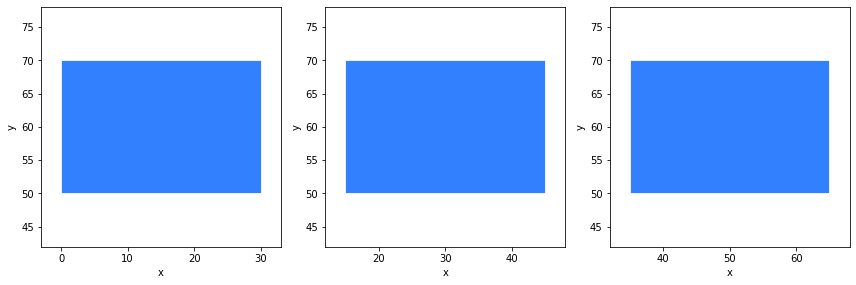

In [3]:
plot(OBSTACLE)

The above plot shows the three obstacles which all have the same shape. Note that the position differs, as expected.

Next, let's run an incompressible fluid simulation.
Note that we can initialize the `smoke` density and `velocity` without the batch dimension `obstacle_pos`.

In [5]:
def step(v, s, p, dt=1.):
    s = advect.mac_cormack(s, v, dt) + INFLOW
    buoyancy = s * (0, 0.1) @ v  # resamples smoke to velocity sample points
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, [OBSTACLE], Solve('auto', 1e-5, 0, x0=p))
    return v, s, p

velocity = StaggeredGrid((0, 0), 0, x=64, y=64, bounds=Box(x=100, y=100))
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=200, y=200, bounds=Box(x=100, y=100))
INFLOW = 0.2 * CenteredGrid(SoftGeometryMask(Sphere(x=50, y=9.5, radius=5)), 0, smoke.bounds, smoke.resolution)
pressure = None

for _ in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure)

<Figure size 864x360 with 3 Axes>

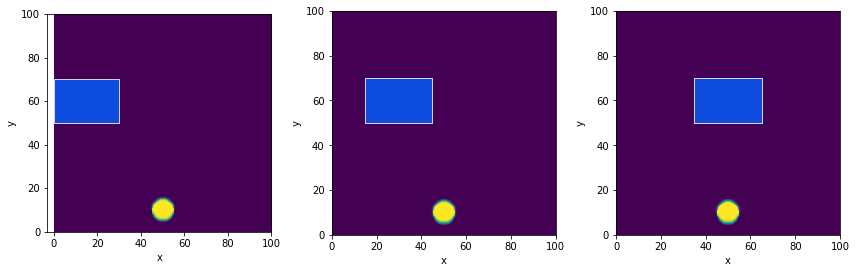

In [7]:
plot(vis.overlay(smoke, OBSTACLE), show_color_bar=False)

<Figure size 864x360 with 3 Axes>

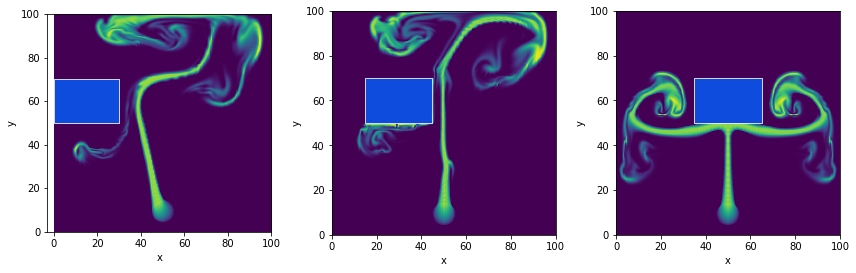

In [9]:
for _ in range(100):
    velocity, smoke, pressure = step(velocity, smoke, pressure)
plot(vis.overlay(smoke, OBSTACLE), show_color_bar=False)